The goal here is to find paths from $s$ to $t$ through $G$ that are vertex disjoint.

Defn of "path":

A path $p$ is an ordered list of edges $p = \langle e_1, e_2, \dots, e_n \rangle$ such that $\forall i, e_i \in E$ and no vertex is visited twice. That is, a vertex can appear only at most twice (into and out of) in any edge in the path. Formally, let $e_i, e_j$ be a arbitrary edges in the path such that $e_i = (u,v)$ and $e_j = (v,w)$. Necessarily, $j = i+1$ since $e_i$ represents the edge into node $v$ and $e_j$ represents the edge out of $v$. By definition of path (cf. "walk"), $\not\exists z \neq u \in V$ st $(z,v) \in p$ and $\not\exists x \neq w \in V$ st $(v,x) \in p$.

Notation note for paths: $p_V$ is defined as the set of all vertices visited by the path. That is, $p_V := \cup_{(u,v) \in p} \{u\} \cup \{v\}$.

Furthermore, $p_s$ is the start vertex: $p_s := e_1[0]$ and $p_t$ is the end vertex: $p_t := e_n[1]$.

Defn of "vertex-disjoint paths":

A path $p$ through a graph $G$ is said to be *vertex-disjoint* from a path $q$ through $G$ (with both $p$ and $q$ starting at $s \in V$ and ending at $t \in V$) iff:

$$
p_V \cap q_V = \{s,t\}
$$

That is, two paths are said to be vertex-disjoint if the only vertices they share in common are the start and end.

In [1]:
import numpy as np
import networkx as nx
import rsa
import matplotlib.pyplot as plt
import scipy.stats
%matplotlib inline

Here is an example of a graph with vertex-disjoint paths between nodes 0 (s) and 3 (t)

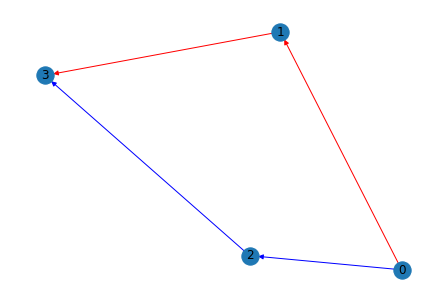

In [24]:
eG = nx.DiGraph()
eG.add_edge(0,1,capacity=1)
eG.add_edge(0,2,capacity=1)
eG.add_edge(1,3,capacity=1)
eG.add_edge(2,3,capacity=1)

nx.draw(eG,with_labels=True,edge_color=['r','b','r','b'])

Here, the red path and the blue path are vertex-disjoint from 0 to 3.

Goal: create a (centralized) algorithm for finding (the number of) vertex-disjoint paths in a graph.

Clearly this number is upper-bounded by the min of the out-degree of $s$ and the in-degree of $t$.

idea: hack max-flow in such a way that it only allows vertices to be used once -- thus solving the count problem. I believe this can be done by just solving max flow on exactly the given graph with each edge having a weight of 1

In [2]:
class TNNode():
    
    def __init__(self,node_id):
        self.id = node_id
        self.private_key = None
        self.public_key = None
        self.neighbors = set()
        self.neighbors_ids = set()
        
        self.is_eve = False
        
        self.generate_keys()
        
    def generate_keys(self):
        self.public_key, self.private_key = rsa.newkeys(16)
    
    '''
    simulates high-fidelity in-person key transfer
    no trust assumptions yet
    '''
    def add_public_key_in_person(self,t_node):
        self.neighbors.add(t_node)
        self.neighbors_ids.add(t_node.id)
    
    '''
    tell me how many *paths* there are from me to some destination node
    naive implementation (assumes no eves)
    '''
    def count_paths_to(self,dest_id):
        #since this is a surrogate for trust, and we're just trying to find keys, infinite trust for already-known keys
        if self.id == dest_id:
            return float('inf')
        if dest_id in self.neighbors_ids:
            return float('inf')
        
        #now we just have to ask our neighbors how many paths there are
        paths = 0
        for neighbor in self.neighbors:
            paths += neighbor.path_count_interm(set(),dest_id)
            
        return paths
            
    '''
    I have been asked by a neighbor to count the number of paths to this person
    '''
    def path_count_interm(self,nodes_visited:set,dest_id):
        if dest_id == self.id:
            return 1#I have 1 path to myself (just a base case so everything works out fine)
        
        #otherwise I'll have to ask my neighbors
        nodes_visited.add(self)
        paths = 0
        for neighbor in (self.neighbors - nodes_visited):
            paths += neighbor.path_count_interm(nodes_visited,dest_id)
        
        return paths

def generate_rand_graph_from_deg_dist(num_nodes,dist = lambda: scipy.stats.truncnorm.rvs(0,float('inf'),loc=3,scale=3),approx_reciprocity=1.):
    #use the social network rand gen algorithm to make a new network
    G = [TNNode(i) for i in range(num_nodes)]
    
    #assign a degree to each node
    degrees = [max(1,int(dist())) for i in range(num_nodes)]#make sure everything is connected to at least one
    connections_left_to_make = {i for i in range(num_nodes)}#these nodes all have connections left to make
    total_connections_to_make = sum(degrees)
    
    #randomly connect the nodes according to their degrees
    connections_made = 0
    while (connections_made < total_connections_to_make) and (len(connections_left_to_make) > 1):
        #pick a random starter node
        i = np.random.choice(list(connections_left_to_make))
        #pick a random other node to assign to
        assign_to = G[np.random.choice(list(connections_left_to_make))]
        G[i].add_public_key_in_person(assign_to)
        connections_made += 1
        degrees[i] -= 1
        if degrees[i] == 0:
            connections_left_to_make.remove(i)
        
        #reciprocity guarantees based on the given number
        if np.random.uniform(0,1) < approx_reciprocity:
            #then add the edge going back to i
            assign_to.add_public_key_in_person(G[i])
            connections_made += 1
            degrees[assign_to.id] -= 1
            if degrees[assign_to.id] == 0:
                connections_left_to_make.remove(assign_to.id)
    
    return G

def convert_to_nx_graph(TNG):
    nxG = nx.DiGraph()
    nxG.add_nodes_from([node.id for node in TNG])
    for node in TNG:
        for connection in node.neighbors:
            nxG.add_edge(node.id,connection.id,capacity=1)
    
    return nxG

In [41]:
'''
transform G st vanilla max flow will count the paths correctly

this we do by adding, for each node with in-degree > 1 and out-degree >1, a dummy node (called a "fork" node)
that the original node points to and moving all of the original node's out-edges to be the out-edges of the fork node
'''
def vertex_disjoint_transform(G):
    Gp = nx.DiGraph()
    Gp.add_edges_from(G.edges)#copy G
    
    for v in list(Gp.nodes):#cast to list so that there are no concurrent modification issues
        #for every vertex
        if (Gp.in_degree(v) > 1) and (Gp.out_degree(v) > 1):#with in and out degree > 1 (forking vertex)
            #do the motif transform
            fork_node = 'f{}'.format(v)
            #assign all of v's out-edges to f* and remove them from v
            for u in list(Gp.neighbors(v)):#cast to list so that there are no concurrent modification issues
                Gp.add_edge(fork_node,u)
                Gp.remove_edge(v,u)
            #point v to the fork node
            Gp.add_edge(v,fork_node)
    
    #assign capacity 1 to all edges
    nx.set_edge_attributes(Gp,1,name='capacity')
    
    return Gp
            

'''
use max flow on a modified version of G to find the number of vertex disjoint paths between s and t
'''
def vertex_disjoint_paths(G,s,t):
    #first modify G so that two-in two-out motifs evaluate correctly
    Gp = vertex_disjoint_transform(G)
    #then run max flow on that graph with the caveat that if we used the fork node transform on s we need to change the start to s
    if 'f{}'.format(s) in Gp.nodes:
        s = 'f{}'.format(s)
        
    return nx.algorithms.flow.edmonds_karp(Gp,s,t).graph['flow_value']

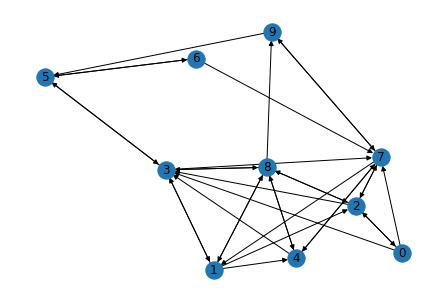

In [34]:
#apparently networkx has an edmonds-karp implementation, let's try that
np.random.seed(0)
G = convert_to_nx_graph(generate_rand_graph_from_deg_dist(10,approx_reciprocity=0.5))
nx.draw(G,with_labels=True)

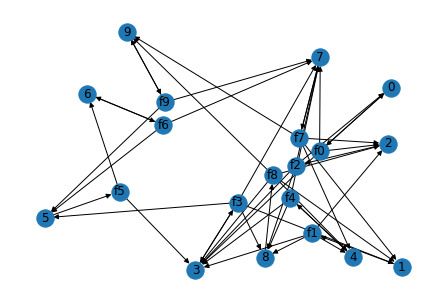

In [36]:
testG = vertex_disjoint_transform(G)
nx.draw(testG,with_labels=True)

In [42]:
vertex_disjoint_paths(G,0,5)

2

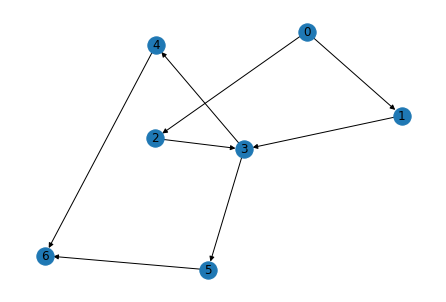

In [21]:
G = nx.DiGraph()
G.add_edge(0,1,capacity=0.5)
G.add_edge(0,2,capacity=0.5)
G.add_edge(1,3,capacity=1)
G.add_edge(2,3,capacity=1)
G.add_edge(3,4,capacity=0.5)
G.add_edge(3,5,capacity=0.5)
G.add_edge(4,6,capacity=1)
G.add_edge(5,6,capacity=1)
nx.draw(G,with_labels=True)

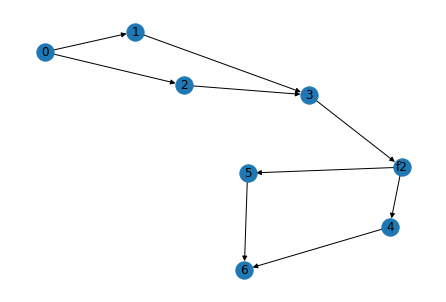

In [44]:
G = nx.DiGraph()
G.add_edge(0,1,capacity=1)
G.add_edge(0,2,capacity=1)
G.add_edge(1,3,capacity=1)
G.add_edge(2,3,capacity=1)
G.add_edge(3,'f2',capacity=1)
G.add_edge('f2',4,capacity=1)
G.add_edge('f2',5,capacity=1)
G.add_edge(4,6,capacity=1)
G.add_edge(5,6,capacity=1)
nx.draw(G,with_labels=True)

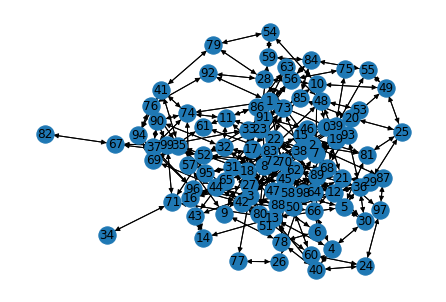

In [45]:
#apparently networkx has an edmonds-karp implementation, let's try that
np.random.seed(0)
G = convert_to_nx_graph(generate_rand_graph_from_deg_dist(100,approx_reciprocity=1.))
nx.draw(G,with_labels=True)

In [48]:
vertex_disjoint_paths(G,55,24)

3

Okay, that seems to work (PROOF NECESSARY NOW), why don't we try something else?

It seems like in this network what we're going to run into (and what we actually care about) is bad vertices. Thus, flow-limiting vertices are more interesting to us than flow-limiting edges. If we can 1) find those flow-limiting vertices and 2) determine multiple disjoint paths to them, we might be able to leverage the network even further to guarantee more about the security of those nodes.